In [1]:
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import *
import pandas as pd
import numpy as np

1. Identify county
2. Assign water consumption to county
3. Fraction of population in a county in a place
4. Fraction of county water consumption to the place 
5. Assign location to place

In [26]:
# Final domestic demand dataframe
cols = ['state_alpha','state_code','place','place_code','county','county_code','place_pop','county_pop_frac','county_water_demand (m3/yr)','place_water_demand (m3/yr)','polygon','centroid']
domestic_demand = pd.DataFrame(columns = cols)

Read county->water demand file

In [27]:
county_water_demand = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/USGS_domestic_metric.csv')

Read county->place map file

In [28]:
county_place_map = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/county_place_map.csv')
county_place_map
# create variables to filter parameters
contiguous_usa = ('AL','AZ','AR','CA','CO','CT','DE','FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE',
                  'NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY','DC')

In [29]:
# Drop non contiguous states
county_place_map_group = county_place_map.sort_values(['STATE','PLACENAME']).groupby('STATE')
county_place_map_group = county_place_map_group.apply(pd.DataFrame).set_index('STATE')
for state in county_place_map_group.index.unique():
    if state in contiguous_usa:
        pass
    else:
        county_place_map_group.drop(index=state,inplace=True) 
county_place_map_group = county_place_map_group.reset_index()

In [30]:
# Remove rows were the place name ends with CDP
idx_list = []
for index,place in county_place_map_group.iterrows():
    # if place['PLACENAME'][-3:] == 'CDP':
        # print(place['PLACENAME'])
    if place['CLASSFP']!='C1':
        idx_list.append(index)

county_place_map_group.drop(index=idx_list,inplace=True) 


Read place -> population files

place_pop_2022 taken from census file SUB-IP-EST2022-POP (https://www2.census.gov/programs-surveys/popest/tables/2020-2022/)

In [31]:
place_pop = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/place_pop_2022.csv')
place_pop.state=place_pop.state.str.strip()

# map state name to state code
path = 'C:/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/data'
df = place_pop
state_abbv_df = pd.read_csv(path + '/state_abbv.csv', index_col='us_state')

df['state_alpha'] = df['state'].map(state_abbv_df.abbv)
# state_abbv_df
place_pop = df

Map county->place->state->population

In [47]:
# county_place_map_group[county_place_map_group['STATE']=='AZ']

In [32]:
# Add every state-county-place population data
# If a place is in two counties, the population is divided for each county
domestic_demand = pd.DataFrame(columns = cols)
# for state in county_place_map_group.STATE.unique():
for state in ['CA']:
    state_code = county_place_map_group[county_place_map_group.STATE == state]['STATEFP'].values[0]
    for county in county_place_map_group[county_place_map_group.STATE == state].COUNTYNAME.unique():
        county_water_demand_var = county_water_demand[(county_water_demand.STATE==state)&(county_water_demand.COUNTY==county)]['DO-WFrTo'].values[0]
        for place in county_place_map_group[(county_place_map_group.STATE == state)  & (county_place_map_group.COUNTYNAME == county)].PLACENAME:
            if place in place_pop[place_pop['state_alpha']==state]['place'].values:
                temp = {'state_alpha':state,
                        'state_code':state_code,
                        'place':place,
                        'place_code':county_place_map_group[(county_place_map_group.STATE == state) & (county_place_map_group.PLACENAME == place) & (county_place_map_group.COUNTYNAME == county)]['PLACEFP'].values[0],
                        'county':county,
                        'county_code':county_place_map_group[(county_place_map_group.STATE == state) & (county_place_map_group.PLACENAME == place) & (county_place_map_group.COUNTYNAME == county)]['COUNTYFP'].values[0],
                        'place_pop': float(place_pop[(place_pop['state_alpha']==state) & (place_pop['place']==place)]['population'])/len(county_place_map_group[(county_place_map_group.STATE == state) & (county_place_map_group.PLACENAME == place)]),
                        'county_pop_frac':0, 
                        'county_water_demand (m3/yr)':county_water_demand_var,
                        'place_water_demand (m3/yr)':0,
                        'polygon':0,
                        'centroid':0,               
                        }
                temp = pd.DataFrame([temp])
                domestic_demand= pd.concat([domestic_demand,temp])
                domestic_demand.reset_index()
# temp
domestic_demand

,state_alpha,state_code,place,place_code,county,county_code,place_pop,county_pop_frac,county_water_demand (m3/yr),place_water_demand (m3/yr),polygon,centroid
0,CA,6,Adelanto city,296,San Bernardino County,71,38783.0,0,1.105340e+05,0,0,0
0,CA,6,Apple Valley town,2364,San Bernardino County,71,75867.0,0,1.105340e+05,0,0,0
0,CA,6,Barstow city,4030,San Bernardino County,71,25231.0,0,1.105340e+05,0,0,0
0,CA,6,Big Bear Lake city,6434,San Bernardino County,71,5031.0,0,1.105340e+05,0,0,0
0,CA,6,Chino Hills city,13214,San Bernardino County,71,77949.0,0,1.105340e+05,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,CA,6,South Lake Tahoe city,73108,El Dorado County,17,21175.0,0,3.868692e+06,0,0,0
0,CA,6,Portola city,58352,Plumas County,63,2041.0,0,3.177854e+05,0,0,0
0,CA,6,San Francisco city,67000,San Francisco County,75,808437.0,0,2.348848e+05,0,0,0
0,CA,6,Sonora city,72674,Tuolumne County,109,4956.0,0,2.487016e+05,0,0,0


In [33]:
# Add place wise population fraction and water demand

for state in domestic_demand.state_alpha.unique():
    for county in county_place_map_group[county_place_map_group.STATE == state].COUNTYNAME.unique():
        frac = domestic_demand[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ]['place_pop']/sum(domestic_demand[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ]['place_pop'])

        domestic_demand.loc[(domestic_demand.state_alpha == state) & (domestic_demand.county == county) ,'county_pop_frac'] = frac

domestic_demand['place_water_demand (m3/yr)'] = domestic_demand['county_pop_frac']*domestic_demand['county_water_demand (m3/yr)']

domestic_demand

,state_alpha,state_code,place,place_code,county,county_code,place_pop,county_pop_frac,county_water_demand (m3/yr),place_water_demand (m3/yr),polygon,centroid
0,CA,6,Adelanto city,296,San Bernardino County,71,38783.0,0.020476,1.105340e+05,2263.29167,0,0
0,CA,6,Apple Valley town,2364,San Bernardino County,71,75867.0,0.040055,1.105340e+05,4427.433388,0,0
0,CA,6,Barstow city,4030,San Bernardino County,71,25231.0,0.013321,1.105340e+05,1472.426375,0,0
0,CA,6,Big Bear Lake city,6434,San Bernardino County,71,5031.0,0.002656,1.105340e+05,293.598236,0,0
0,CA,6,Chino Hills city,13214,San Bernardino County,71,77949.0,0.041154,1.105340e+05,4548.934388,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,CA,6,South Lake Tahoe city,73108,El Dorado County,17,21175.0,0.665065,3.868692e+06,2572930.834566,0,0
0,CA,6,Portola city,58352,Plumas County,63,2041.0,1.0,3.177854e+05,317785.3823,0,0
0,CA,6,San Francisco city,67000,San Francisco County,75,808437.0,1.0,2.348848e+05,234884.8478,0,0
0,CA,6,Sonora city,72674,Tuolumne County,109,4956.0,1.0,2.487016e+05,248701.6035,0,0


Map state->place->polygon+centroid

In [46]:
# domestic_demand[(domestic_demand.state_code == state_code)]

In [41]:
# Read file based on state code and find location based on place for each county

location_file_path = '/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/domestic_location_files/'

domestic_demand['place_code'] = domestic_demand['place_code'].astype('int64')

for state_code in domestic_demand.state_code.unique():
    file_name = 'tl_rd22_' + str(f'{state_code:02d}') + '_place'
    file_path = location_file_path + file_name + '/' + file_name +'.shp'
    df = gp.read_file(file_path)
    df = df.to_crs("EPSG:4326")
    df['PLACEFP'] = df['PLACEFP'].astype(int)
    df = df.set_index('PLACEFP')
    
    domestic_demand.loc[domestic_demand.state_code == state_code,'polygon'] = domestic_demand[domestic_demand.state_code == state_code]['place_code'].map(df.geometry)
    
    # for place_code in domestic_demand[domestic_demand.state_code == state_code].place_code:
    #     domestic_demand.loc[(domestic_demand.state_code == state_code) & (domestic_demand.place_code == place_code),'polygon']  = df[(df.STATEFP == str(state_code)) & (df.PLACEFP== str(place_code))].geometry

domestic_demand.centroid = domestic_demand.polygon.values.centroid.to_crs("EPSG:4326")
domestic_demand

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\IPython\core\interactiveshell.py:3382: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if await self.run_code(code, result, async_=asy):


,state_alpha,state_code,place,place_code,county,county_code,place_pop,county_pop_frac,county_water_demand (m3/yr),place_water_demand (m3/yr),polygon,centroid
0,CA,6,Adelanto city,296,San Bernardino County,71,38783.0,0.020476,1.105340e+05,2263.29167,"MULTIPOLYGON (((-117.33809 34.57990, -117.3378...",POINT (-117.43969 34.58140)
0,CA,6,Apple Valley town,2364,San Bernardino County,71,75867.0,0.040055,1.105340e+05,4427.433388,"POLYGON ((-117.28734 34.53355, -117.28731 34.5...",POINT (-117.21090 34.53520)
0,CA,6,Barstow city,4030,San Bernardino County,71,25231.0,0.013321,1.105340e+05,1472.426375,"POLYGON ((-117.15366 34.87299, -117.15366 34.8...",POINT (-117.04711 34.86605)
0,CA,6,Big Bear Lake city,6434,San Bernardino County,71,5031.0,0.002656,1.105340e+05,293.598236,"POLYGON ((-116.96229 34.23773, -116.96229 34.2...",POINT (-116.89527 34.24290)
0,CA,6,Chino Hills city,13214,San Bernardino County,71,77949.0,0.041154,1.105340e+05,4548.934388,"POLYGON ((-117.80254 33.97555, -117.80078 33.9...",POINT (-117.72540 33.95083)
...,...,...,...,...,...,...,...,...,...,...,...,...
0,CA,6,South Lake Tahoe city,73108,El Dorado County,17,21175.0,0.665065,3.868692e+06,2572930.834566,"POLYGON ((-120.02294 38.93406, -120.01825 38.9...",POINT (-119.98272 38.93929)
0,CA,6,Portola city,58352,Plumas County,63,2041.0,1.0,3.177854e+05,317785.3823,"MULTIPOLYGON (((-120.46698 39.81805, -120.4669...",POINT (-120.47325 39.82414)
0,CA,6,San Francisco city,67000,San Francisco County,75,808437.0,1.0,2.348848e+05,234884.8478,"MULTIPOLYGON (((-122.61228 37.81522, -122.5845...",POINT (-122.69396 37.75972)
0,CA,6,Sonora city,72674,Tuolumne County,109,4956.0,1.0,2.487016e+05,248701.6035,"POLYGON ((-120.40196 37.98953, -120.39921 37.9...",POINT (-120.38281 37.98189)


In [35]:
# domestic_demand.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/ca_demand_location.csv',
#                        columns=['state_alpha','state_code','place','place_code','county','county_code','place_pop','county_pop_frac','county_water_demand (m3/yr)','place_water_demand (m3/yr)'])

In [4]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

<AxesSubplot: >

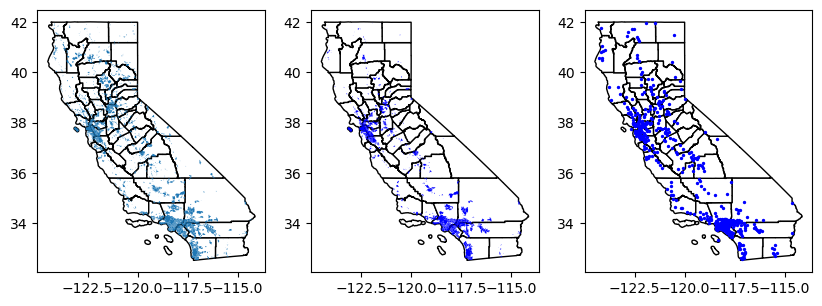

In [44]:
ca = us_counties.loc[us_counties['STATEFP']=='06']

ca_place = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/domestic_location_files/tl_rd22_06_place/tl_rd22_06_place.shp' )
ca_place = ca_place.to_crs("EPSG:4326")

fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize = (10,15))
ca.plot(ax=ax,figsize=(50, 50),color = 'white',edgecolor ='black')
ca_place.plot(ax=ax, markersize = 5,label='PP')

# Places available in the census data for places
ca.plot(ax=ax1,figsize=(50, 50),color = 'white',edgecolor ='black')
places = gp.GeoSeries(domestic_demand.polygon)
places.plot(ax=ax1, color='blue', markersize = 5,label='PP')


# Centroid of population data for places (does not include CDP)
ca.plot(ax=ax2,figsize=(50, 50),color = 'white',edgecolor ='black')
centroids = gp.GeoSeries(domestic_demand.centroid.values)
centroids.plot(ax=ax2, color='blue', markersize = 2,label='PP')



In [37]:
pd.DataFrame(ca_place)
ca_place
ca_place.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/ca_all_places.csv',columns = ['STATEFP','NAME','NAMELSAD'])

<AxesSubplot: >

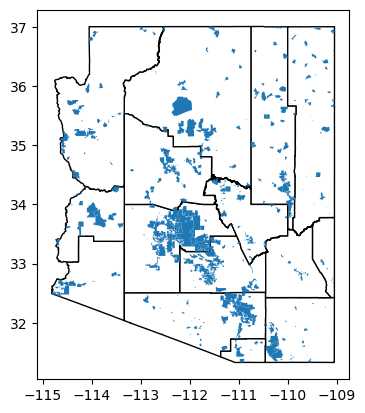

In [13]:
az = us_counties.loc[us_counties['STATEFP']=='04']

az_place = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/domestic_location_files/tl_rd22_04_place/tl_rd22_04_place.shp' )
az_place = az_place.to_crs("EPSG:4326")

fig, (ax,ax1,ax2) = plt.subplots(1,3)

# All places
az.plot(ax=ax,figsize=(50, 50),color = 'white',edgecolor ='black')
az_place.plot(ax=ax, markersize = 5,label='PP')
az.plot(ax=ax,figsize=(50, 50),color = 'white',edgecolor ='black')

# Places available in the census data for places
places = gp.GeoSeries(domestic_demand.polygon)
places.plot(ax=ax1, color='blue', markersize = 5,label='PP')

# Centroid of population data for places (does not include CDP)
centroids = gp.GeoSeries(domestic_demand.centroid.values)
centroids.plot(ax=ax2, color='blue', markersize = 5,label='PP')
az.plot(ax=ax1,figsize=(50, 50),color = 'white',edgecolor ='black')



In [25]:
pd.DataFrame(az_place)
az_place
az_place.to_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/az_all_places.csv',columns = ['STATEFP','NAME','NAMELSAD'])

<AxesSubplot: >

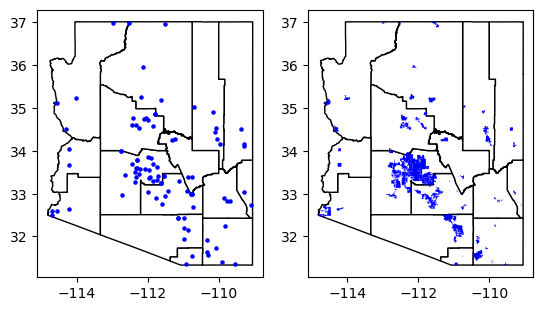

In [14]:
# df = gp.read_file('/Users/mhardika/Downloads/tl_2016_04_cousub/tl_2016_04_cousub.shp')
# df = df.to_crs("EPSG:4326")
# fig, (ax,ax1) = plt.subplots(1,2)
# df.plot(ax=ax,figsize=(50, 50))


Comparison of county census population vs total city+town population

In [65]:
df = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Domestic\Census Data\co-est2022-alldata.csv')
df1 = df[df['STATE']==6].groupby('CTYNAME').first()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,...,RDEATH2021,RDEATH2022,RNATURALCHG2021,RNATURALCHG2022,RINTERNATIONALMIG2021,RINTERNATIONALMIG2022,RDOMESTICMIG2021,RDOMESTICMIG2022,RNETMIG2021,RNETMIG2022
CTYNAME,,,,,,,,,,,,,,,,,,,,,
Alameda County,50,4,9,6,1,California,1682331,1680380,1643837,1628997,...,7.219745,6.746447,2.890906,3.822375,2.548570,7.109435,-26.257612,-20.282727,-23.709042,-13.173293
Alpine County,50,4,9,6,3,California,1201,1204,1235,1190,...,16.400164,15.670103,-8.200082,-9.072165,0.000000,0.824742,37.720377,-29.690722,37.720377,-28.865979
Amador County,50,4,9,6,5,California,40474,40532,41144,41412,...,14.006563,12.573284,-6.611489,-4.917874,0.195896,0.484520,22.332142,10.683657,22.528038,11.168177
Butte County,50,4,9,6,7,California,211631,210135,206190,207303,...,12.538281,11.797056,-2.992854,-1.886368,0.307452,0.836774,-15.766529,6.287894,-15.459076,7.124667
Calaveras County,50,4,9,6,9,California,45285,45346,46219,46563,...,13.520450,12.373090,-5.460602,-4.224957,0.174739,0.517342,25.402719,10.821064,25.577459,11.338406
California,40,4,9,6,0,California,39538245,39501653,39142991,39029342,...,8.787630,8.148586,1.694813,2.715923,1.122034,3.216355,-11.671513,-8.781368,-10.549479,-5.565012
Colusa County,50,4,9,6,11,California,21837,21858,21913,21914,...,8.544470,7.985945,4.432158,5.430442,0.274154,-0.136902,-2.878618,-5.247907,-2.604464,-5.384808
Contra Costa County,50,4,9,6,13,California,1165927,1165986,1163298,1156966,...,8.303839,7.556037,1.679486,2.749687,1.438210,4.093500,-5.845573,-12.540814,-4.407363,-8.447315
Del Norte County,50,4,9,6,15,California,27745,27601,27553,27082,...,12.329115,12.446234,-3.517424,-3.441018,0.398883,0.841951,0.870290,-15.228333,1.269174,-14.386382


In [62]:
county_pop_calc = pd.DataFrame(columns = ['county','population'])
county_list = domestic_demand.county.unique()

for county in county_list:
    temp = {'county': county,
            'population':domestic_demand[domestic_demand['county']==county]['place_pop'].sum()}

    temp = pd.DataFrame([temp])
    county_pop_calc= pd.concat([county_pop_calc,temp])

county_pop_calc.reset_index()
county_pop_calc= county_pop_calc.sort_values(by=['county'])


ValueError: shape mismatch: objects cannot be broadcast to a single shape

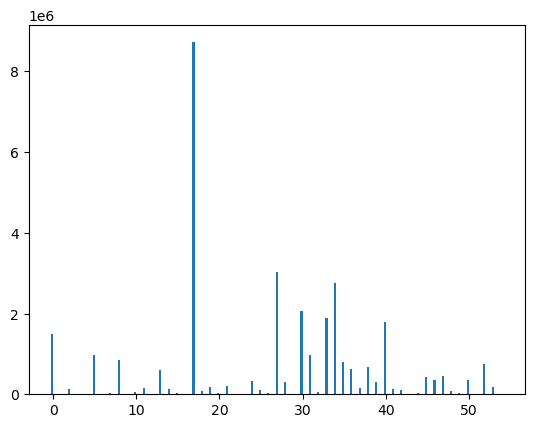

In [63]:
county_list = county_pop_calc.county.unique()
fig,ax = plt.subplots()
x = np.array(range(0,len(county_list)))

ax.bar(x-0.125, county_pop_calc['population'], width = 0.25,label='City/Town')
ax.bar(x+0.125, df1['POPESTIMATE2022'], width = 0.25, label = 'County level Census')
ax.legend()

ax.set_xticks(range(0,len(county_list)),county_list,rotation = 90)

In [75]:
county_pop_calc['population'].sum()/df1['POPESTIMATE2022'].sum()

0.4170863295619998

<AxesSubplot: >

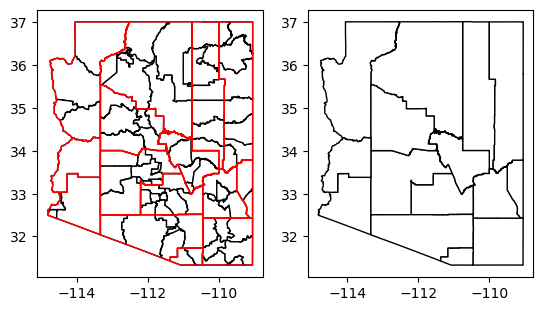

In [16]:
az = us_counties.loc[us_counties['STATEFP']=='04']
az_cousub = gp.read_file(r'\Users\mhardika\Downloads\tl_rd22_04_cousub\tl_rd22_04_cousub.shp' )
az_cousub  =az_cousub .to_crs("EPSG:4326")

fig, (ax,ax0) = plt.subplots(1,2)

# All places
az_cousub.plot(ax=ax,figsize=(50, 50),color = 'white',edgecolor ='black')
az.plot(ax=ax,figsize=(50, 50),facecolor ='none',edgecolor ='red')

az.plot(ax=ax0,figsize=(50, 50),color = 'white',edgecolor ='black')


County Subdivision Basis

In [55]:
cousub = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Domestic/Census Data/DECENNIALPL2020.P1_2023-07-17T155825/county_subdivision_data_2020.csv',encoding='utf-8')
cousub.head()

,GEO_ID,NAME,POP
0,0600000US0100190171,"Autaugaville CCD, Autauga County, Alabama",3185
1,0600000US0100190315,"Billingsley CCD, Autauga County, Alabama",2645
2,0600000US0100192106,"Marbury CCD, Autauga County, Alabama",6359
3,0600000US0100192628,"Prattville CCD, Autauga County, Alabama",46616
4,0600000US0100390207,"Bay Minette CCD, Baldwin County, Alabama",25186


In [93]:
tmpDF = pd.DataFrame(columns=['subdiv','county','state','pop'])

try:
    tmpDF[['subdiv','county','state']] = cousub['NAME'].str.split(", ",expand=True)
    print('ok')
except ValueError:
    # tmpDF[['subdiv','county','state']] = cousub['NAME'].str.split(", ",expand=True)
    # subdiv = cousub['NAME'].str.split(", ",expand=True)
    # county = cousub['NAME'].str.split(", ",expand=True)[-2]
    # state = cousub['NAME'].str.split(", ",expand=True)[-1]
    # tmpDF['subdiv'] = subdiv
    # tmpDF['county'] = county
    # tmpDF['state'] = state
    print('wrong')
tmpDF['pop'] = cousub['POP']
tmpDF.head()

wrong


,subdiv,county,state,pop
0,NaN,NaN,NaN,3185
1,NaN,NaN,NaN,2645
2,NaN,NaN,NaN,6359
3,NaN,NaN,NaN,46616
4,NaN,NaN,NaN,25186


In [83]:
for state in tmpDF.state.unique():
    num = len(tmpDF[tmpDF['state']== state].county.unique())
    print(state + f': {num}')

Alabama: 67
Alaska: 30
Arizona: 15
Arkansas: 75
California: 58
Colorado: 64
Connecticut: 8
Delaware: 3
District of Columbia: 1
Florida: 67
Georgia: 159
Hawaii: 5
Idaho: 44
Illinois: 102
Indiana: 92
Iowa: 99
Kansas: 105
Kentucky: 120
Louisiana: 64
Maine: 16
Allegany County: 22
Maryland: 4
Calvert County: 3
Caroline County: 8
Carroll County: 14
Cecil County: 9
Charles County: 10
Dorchester County: 18
Frederick County: 26
Garrett County: 16
Harford County: 6
Howard County: 6
Kent County: 7
Prince George's County: 21
Queen Anne's County: 7
St. Mary's County: 9
Somerset County: 15
Talbot County: 5
Washington County: 23
Wicomico County: 15
Worcester County: 7
Massachusetts: 14
Michigan: 83
Minnesota: 87
Mississippi: 82
Missouri: 115
Montana: 56
Nebraska: 92
Pawnee County: 5
Nevada: 17
New Hampshire: 10
New Jersey: 21
New Mexico: 33
New York: 62
Alamance County: 13
North Carolina: 91
Cabarrus County: 12
Chowan County: 4
Edgecombe County: 14
Jones County: 7
Lee County: 7
Madison County: 12
Mec

In [65]:
sum(tmpDF[tmpDF['county']=='Jackson County']['pop'])

1771977